# Seq2seq 프로젝트: 한영 번역기 만들기

In [50]:
# 한글폰트 설치: 실행후 런타임 재시작 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 6 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,380 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120882 files and direc

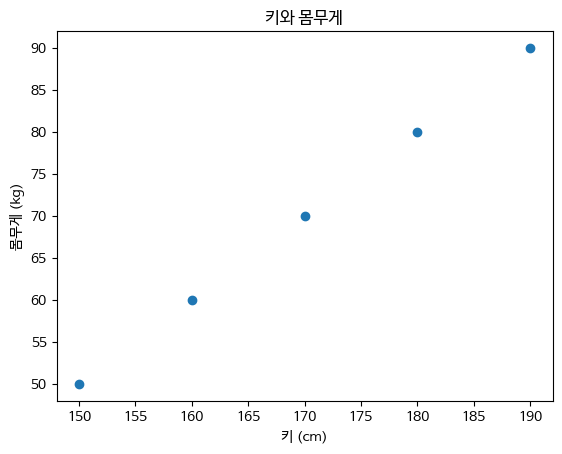

In [1]:
# 한글 표시 여부 확인
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕 적용하기

# 예제 데이터
heights = [150, 160, 170, 180, 190]  # 키 (cm)
weights = [50, 60, 70, 80, 90]       # 몸무게 (kg)

# 산점도 그리기
plt.scatter(heights, weights)

# 제목 및 레이블 추가
plt.title("키와 몸무게")
plt.xlabel("키 (cm)")
plt.ylabel("몸무게 (kg)")

# 그래프 표시
plt.show()

## 데이터 정제

In [2]:
# 학습 데이터 다운로드
!git clone https://github.com/jungyeul/korean-parallel-corpora.git

# 한-영 뉴스 코퍼스 압축해제
!mkdir kor-eng-train
!tar -xzf ./korean-parallel-corpora/korean-english-news-v1/korean-english-park.train.tar.gz -C kor-eng-train/

Cloning into 'korean-parallel-corpora'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 173 (delta 18), reused 0 (delta 0), pack-reused 131
Receiving objects: 100% (173/173), 20.48 MiB | 15.25 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [5]:
# 데이터 확인
def read_and_print_examples(file_path, num_examples=100, step=20):
    with open(file_path, "r", encoding='utf-8') as f:
        raw = f.read().splitlines()

    print(f"Data Size in {file_path}: {len(raw)}")
    print("Examples:")

    for sen in raw[:num_examples:step]:
        print(">>", sen)

# 영어 파일 읽기 및 출력
read_and_print_examples("./kor-eng-train/korean-english-park.train.en")

# 한국어 파일 읽기 및 출력
read_and_print_examples("./kor-eng-train/korean-english-park.train.ko")

Data Size in ./kor-eng-train/korean-english-park.train.en: 94123
Examples:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.
Data Size in ./kor-eng-train/korean-english-park.train.ko: 94123
Examples:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를

In [4]:
# 설치 후 런타임 다시 시작 필요
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!bash /content/Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91
Receiving objects: 100% (138/138), 1.72 MiB | 27.88 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Installing konlpy.....
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 53.8 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-11-15 01:19:39--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbu

In [ ]:
import re
from konlpy.tag import Mecab
import collections

# 공통 전처리 함수
def preprocess_text(sentence, lang='kor'):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  # 구두점 분리
    sentence = re.sub(r'[" "]+', " ", sentence)  # 공백 제거
    if lang == 'kor':
        sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)  # 한글 및 구두점 외 문자 제거
    else:
        sentence = sentence.lower()
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)  # 영어 및 구두점 외 문자 제거
        sentence = f"<start> {sentence.strip()} <end>"
    return sentence.strip()

# 데이터 읽기 및 예외 처리
def read_data(file_path):
    try:
        with open(file_path, "r", encoding='utf-8') as file:
            return file.read().splitlines()
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return []

# 파일 읽기
kor_sentences = read_data("./kor-eng-train/korean-english-park.train.ko")
eng_sentences = read_data("./kor-eng-train/korean-english-park.train.en")

# 중복 제거 (동일한 인덱스의 쌍을 유지)
cleaned_corpus = list(set(zip(kor_sentences, eng_sentences)))

# 데이터 전처리 및 토큰화
mecab = Mecab()
kor_corpus = [mecab.morphs(preprocess_text(kor)) for kor, eng in cleaned_corpus if len(mecab.morphs(preprocess_text(kor))) <= 40]
eng_corpus = [preprocess_text(eng, 'eng').split() for kor, eng in cleaned_corpus if len(preprocess_text(eng, 'eng').split()) <= 40]

# 결과 확인
print("Sample Korean Sentence:", kor_corpus[0])
print("Sample English Sentence:", eng_corpus[0])
print("Total Data Size:", len(kor_corpus))

In [ ]:
import tensorflow as tf

# 토큰화 함수
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

# 한국어와 영어 데이터를 토큰화합니다.
kor_tensor, kor_tokenizer = tokenize(kor_corpus)
eng_tensor, eng_tokenizer = tokenize(eng_corpus)

## 바흐다노(Bahdanau) 어텐션 기반 인코더-디코더 설계

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dropout_rate=0.3):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.embedding(x)
        x = self.gru(x)
        x = self.dropout(x)
        return x

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)

    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))

        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, dropout_rate=0.3):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state=True)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vec, 1), x], axis=-1)
        x, h_dec = self.gru(x)
        x = self.dropout(x)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc(x)
        return x, h_dec, attn

In [24]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(kor_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(eng_tokenizer.index_word) + 1

# 모델 초기화
embedding_dim = 256  # Embedding 크기 조정
units = 512          # Hidden size 조정

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30
sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))

# Encoder 호출
sample_output = encoder(sample_enc)

print('Encoder Output:', sample_output.shape)

# Decoder 호출을 위한 초기 상태 설정
# Encoder의 마지막 숨겨진 상태를 가져오기 위해 GRU 레이어의 수정이 필요합니다.
# 현재 Encoder 클래스 정의에는 return_state 옵션이 없으므로, 이를 추가해야 합니다.
sample_decoder_input = tf.random.uniform((BATCH_SIZE, 1))
sample_logits, h_dec, attn = decoder(sample_decoder_input, sample_output[:, -1, :], sample_output)

print('Decoder Output:', sample_logits.shape)
print('Decoder Hidden State:', h_dec.shape)
print('Attention:', attn.shape)

Encoder Output: (64, 30, 512)
Decoder Output: (64, 38524)
Decoder Hidden State: (64, 512)
Attention: (64, 30, 1)


## 훈련

In [33]:
# optimizer & 손실함수 정의
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    return tf.reduce_mean(loss)

In [34]:
# 훈련 단계 구현
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]

        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [37]:
from tqdm import tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, kor_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_tensor[idx:idx+BATCH_SIZE],
                                eng_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 987/987 [04:37<00:00,  3.55it/s, Loss 2.6084]


## 테스트

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 번역 및 어텐션 가중치 시각화 함수
# 번역 및 어텐션 가중치 시각화 함수
def evaluate(sentence, encoder, decoder, kor_tokenizer, eng_tokenizer, enc_train, dec_train):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))

    mecab = Mecab()
    sentence = preprocess_text(sentence)
    sentence = ' '.join(mecab.morphs(sentence))  # MeCab 형태소 분석
    inputs = kor_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=enc_train.shape[-1], padding='post')

    result = ''
    enc_out = encoder(inputs)
    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()
        result += eng_tokenizer.index_word[predicted_id] + ' '

        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def translate(sentence, encoder, decoder, kor_tokenizer, eng_tokenizer, enc_train, dec_train):
    result, sentence, attention = evaluate(sentence, encoder, decoder, kor_tokenizer, eng_tokenizer, enc_train, dec_train)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

In [4]:
# 예문 번역 및 어텐션 가중치 시각화
kor_examples = ["오바마는 대통령이다.", "시민들은 도시 속에 산다.", "커피는 필요 없다.", "일곱 명의 사망자가 발생했다."]
for sentence in kor_examples:
    translate(sentence, encoder, decoder, kor_tokenizer, eng_tokenizer, kor_tensor, eng_tensor)


NameError: ignored